In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data_frames/samsung_train.txt")
y_train = np.loadtxt("../data_frames/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data_frames/samsung_test.txt")
y_test = np.loadtxt("../data_frames/samsung_test_labels.txt").astype(int)

In [5]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [11]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [13]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [14]:
n_classes = np.unique(y).size

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [44]:
round(pca.explained_variance_ratio_[0] * 100)

51

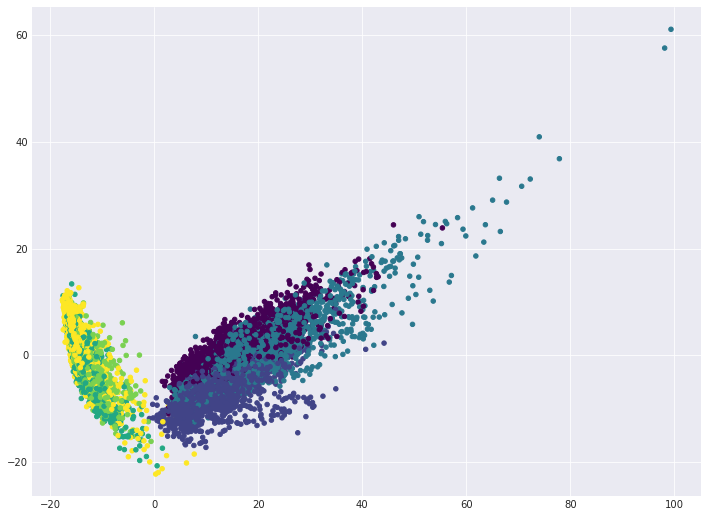

In [46]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

In [50]:
km = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
km.fit(X_pca)
cluster_labels = km.labels_

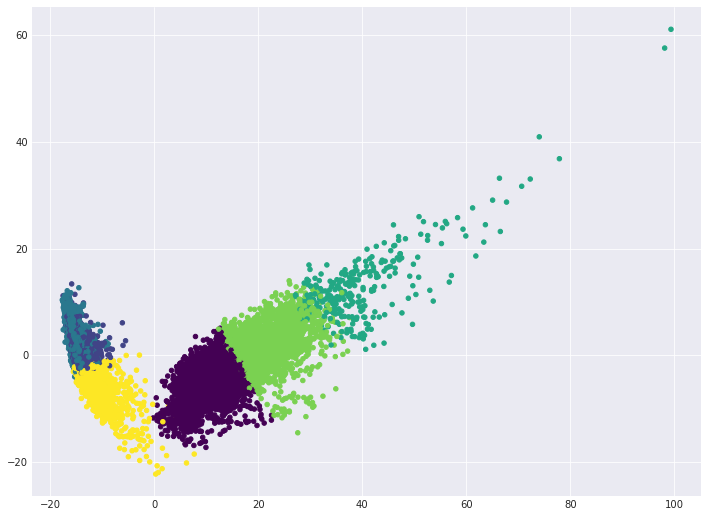

In [52]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

In [53]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                         903         0         0        78       741   
подъем вверх по лестнице      1241         0         0         5       296   
спуск по лестнице              320         0         0       196       890   
сидение                          1      1235        91         0         0   
стояние                          0      1344         0         0         0   
лежание                          5        52      1558         0         0   
все                           2470      2631      1649       279      1927   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         2   1544  
спуск по лестнице                0   1406  
сидение                        450   1777  
стояние                        562   1906  
лежание                        329   1944  
все                           1343  10299

In [61]:
tab.apply(lambda x: x / tab['все']).drop(['все'], axis=1).max(axis=1)

ходьба                      0.524390
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
все                         0.255462
dtype: float64

In [67]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_));

<ipython-input-67-c81ab2c35901>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

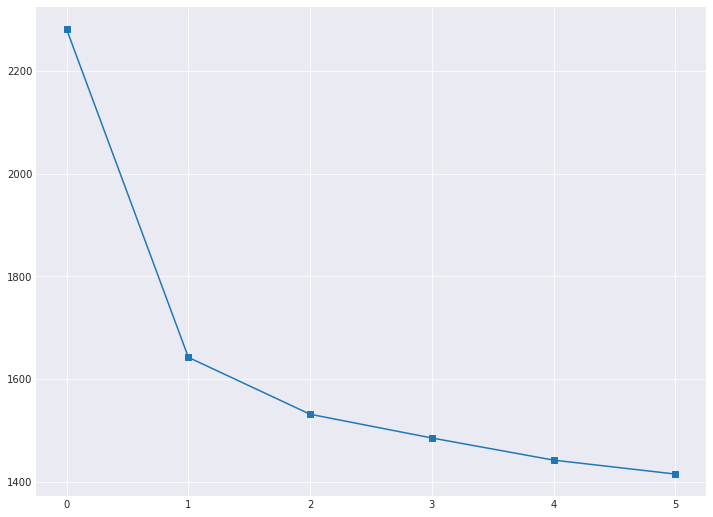

In [66]:
plt.plot(inertia, marker='s')

In [71]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)
ag_labels = ag.labels_

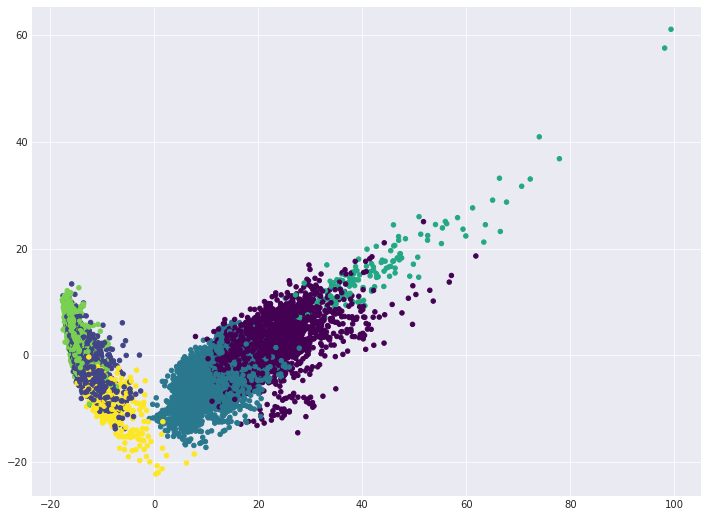

In [72]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ag_labels, s=20, cmap='viridis');

In [79]:
print(metrics.adjusted_rand_score(y, ag_labels))
print(metrics.adjusted_rand_score(y, cluster_labels))

0.49362763373004886
0.4198070012602345


# Linear SVM

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [89]:
best_svc = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1);
best_svc.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

In [92]:
best_svc.best_estimator_, best_svc.best_score_

(LinearSVC(C=0.1, random_state=17), 0.9382506099134881)

In [93]:
y_predicted = best_svc.predict(X_test_scaled)

In [94]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         3                414   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       468                414   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       426       61        0   491  
стояние                        15      517        0   532  
лежание                         0       11      526   537  
все                           442      589      526  2947

In [96]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       496
           2       0.98      0.97      0.98       471
           3       1.00      0.99      0.99       420
           4       0.96      0.87      0.91       491
           5       0.88      0.97      0.92       532
           6       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [100]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [104]:
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1);
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\EduPr\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'